In [365]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set plotting style for better visualization
plt.style.use('ggplot')

In [366]:
# --- Load Data From File ---
# Make sure 'nasdaq_historical.csv' is in the same directory as your notebook.
file_path = 'nasdaq_historical.csv'
try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded data from {file_path}")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please make sure the CSV file is in the same directory as your notebook.")
    # Stop execution if the file is not found
    df = pd.DataFrame() # Create an empty DataFrame to avoid further errors

if not df.empty:
    # --- Data Cleaning ---
    # The column names are based on your example: 'observation_date', 'NASDAQCOM'
    # If your CSV has different column names, you must change them here.
    date_col = 'observation_date'
    price_col = 'NASDAQCOM'

    # Convert date column to datetime objects
    df[date_col] = pd.to_datetime(df[date_col])

    df = df[df[date_col] >= '2010-02-08'].copy()

    # Convert NASDAQCOM to numeric, coercing errors will turn non-numbers into NaN
    df[price_col] = pd.to_numeric(df[price_col], errors='coerce')

    # Forward-fill the missing values (NaNs)
    df[price_col] = df[price_col].ffill()

    # Set the date as the index
    df.set_index(date_col, inplace=True)

    # Calculate the daily percentage return of the NASDAQ index
    df['Index_Return'] = df[price_col].pct_change()

    # Drop the first row as it has no return value
    df.dropna(inplace=True)

    print("Data prepared successfully.")

Successfully loaded data from nasdaq_historical.csv
Data prepared successfully.


In [367]:
daily_mean = df['Index_Return'].mean()
yearly_mean = np.pow((daily_mean + 1), 252)
print(yearly_mean)
df.head()

1.1729459375353362


,NASDAQCOM,Index_Return
observation_date,,
2010-02-09,2150.87,0.011674
2010-02-10,2147.87,-0.001395
2010-02-11,2177.41,0.013753
2010-02-12,2183.53,0.002811
2010-02-15,2183.53,0.000000


In [368]:
# --- Dynamic TER Calculation based on Leverage ---

# Define the known data points (Leverage vs. TER)
# TER for 1x: 0.3%, 2x: 0.6%, 3x: 0.75%
leverage_points = np.array([1, 2, 3])
ter_points = np.array([0.0015, 0.006, 0.0075])

# Fit a quadratic polynomial (degree=2) to the data points.
# This finds the coefficients a, b, c for the equation: TER = a*L^2 + b*L + c
coefficients = np.polyfit(leverage_points, ter_points, 2)

# Create a callable polynomial function from the coefficients
ter_function = np.poly1d(coefficients)

# Display the calculated quadratic equation for transparency
a, b, c = coefficients
print("--- Dynamic Expense Ratio Model ---")
print(f"Fitted Quadratic Equation: TER = {a:.6f}*L^2 + {b:.6f}*L + {c:.6f}")
print("Where L is the leverage factor.")
print("-----------------------------------")

--- Dynamic Expense Ratio Model ---
Fitted Quadratic Equation: TER = -0.001500*L^2 + 0.009000*L + -0.006000
Where L is the leverage factor.
-----------------------------------


In [369]:
# --- Simulation Parameters ---

# Set your desired leverage factor
LEVERAGE_FACTOR = 3

# Annual Expense Ratio (e.g., 0.75%)
EXPENSE_RATIO = ter_function(LEVERAGE_FACTOR)
print(EXPENSE_RATIO)

# Annual Swap Spread (e.g., 0.40% or 40 basis points)
SWAP_SPREAD = 0.0040

# Trading Cost Factor (e.g., 0.03% or 3 basis points)
TRADING_COST_FACTOR = 0.002847

# Assumed annual SOFR rate (e.g., 4.5%)
# Using a fixed rate for this long-term historical simulation.
SOFR_RATE = 0.0025

0.007499999999999993


In [370]:
if not df.empty:
    # --- Daily Performance Calculation ---

    # Gross Leveraged Return
    gross_return = LEVERAGE_FACTOR * df['Index_Return']

    # Daily Financing Cost
    # Note: In a real scenario, SOFR would change daily. Here we use our fixed rate.
    daily_financing_cost = (LEVERAGE_FACTOR - 1) * (SOFR_RATE + SWAP_SPREAD) / 365

    # Daily Expense Ratio Cost
    daily_er_cost = (1 + EXPENSE_RATIO)**(1/365) - 1

    # Daily Trading Cost (variable, depends on market volatility)
    daily_trading_cost = df['Index_Return'].abs() * LEVERAGE_FACTOR * TRADING_COST_FACTOR

    df['daily_trading_cost'] = daily_trading_cost

    # Final LETF Daily Return
    df['LETF_Return'] = gross_return - daily_financing_cost - daily_er_cost - daily_trading_cost

    print("Simulation complete. Showing the first 5 rows with calculated LETF returns:")
    print(df.head())

Simulation complete. Showing the first 5 rows with calculated LETF returns:
                  NASDAQCOM  Index_Return  daily_trading_cost  LETF_Return
observation_date                                                          
2010-02-09          2150.87      0.011674            0.000100     0.034867
2010-02-10          2147.87     -0.001395            0.000012    -0.004252
2010-02-11          2177.41      0.013753            0.000117     0.041086
2010-02-12          2183.53      0.002811            0.000024     0.008352
2010-02-15          2183.53      0.000000            0.000000    -0.000056


--- Final Performance ---
Initial Investment on 2010-02-09: $2,150.87
End Date: 2025-05-29
NASDAQ Composite Final Value: $19,399.73
Simulated LETF Final Value:   $126,479.08
-------------------------


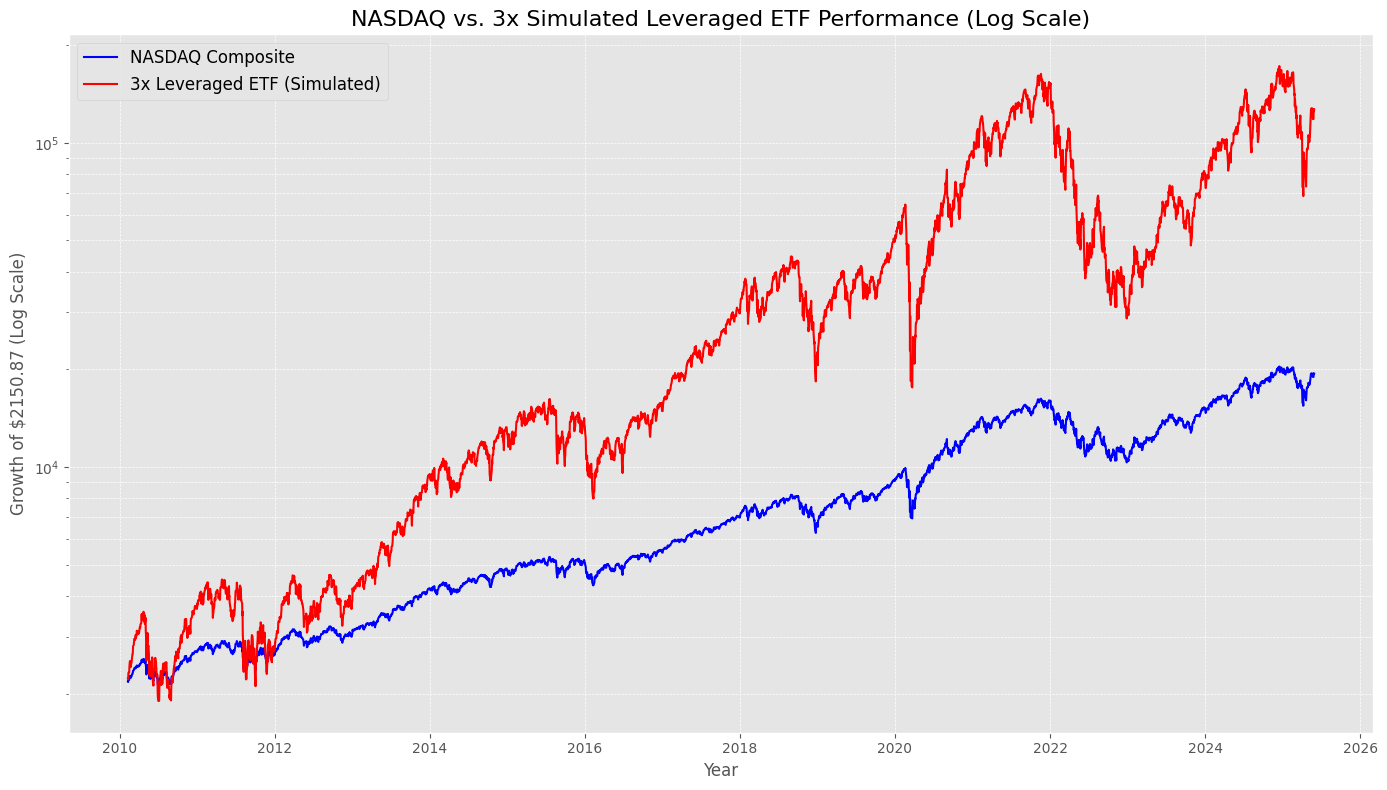

In [371]:
if not df.empty:
    # --- Calculate Cumulative Growth and Plot ---

    # We start the cumulative product from the first price in the original dataframe
    initial_price = df[price_col].iloc[0]

    df['Index_Performance'] = initial_price * (1 + df['Index_Return']).cumprod()
    df['LETF_Performance'] = initial_price * (1 + df['LETF_Return']).cumprod()


    end_price_index = df['Index_Performance'].iloc[-1]
    end_price_letf = df['LETF_Performance'].iloc[-1]

    print("--- Final Performance ---")
    print(f"Initial Investment on {df.index[0].date()}: ${initial_price:,.2f}")
    print(f"End Date: {df.index[-1].date()}")
    print(f"NASDAQ Composite Final Value: ${end_price_index:,.2f}")
    print(f"Simulated LETF Final Value:   ${end_price_letf:,.2f}")
    print("-------------------------")

    # Plotting
    plt.figure(figsize=(14, 8))

    plt.plot(df.index, df['Index_Performance'], label='NASDAQ Composite', color='blue', linewidth=1.5)
    plt.plot(df.index, df['LETF_Performance'], label=f'{LEVERAGE_FACTOR}x Leveraged ETF (Simulated)', color='red', linewidth=1.5)

    # Use a logarithmic scale for the y-axis to better visualize long-term growth
    plt.yscale('log')

    # Formatting
    plt.title(f'NASDAQ vs. {LEVERAGE_FACTOR}x Simulated Leveraged ETF Performance (Log Scale)', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(f'Growth of ${initial_price:.2f} (Log Scale)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    plt.show()

Running batch simulation... This may take a moment.
Batch simulation complete.


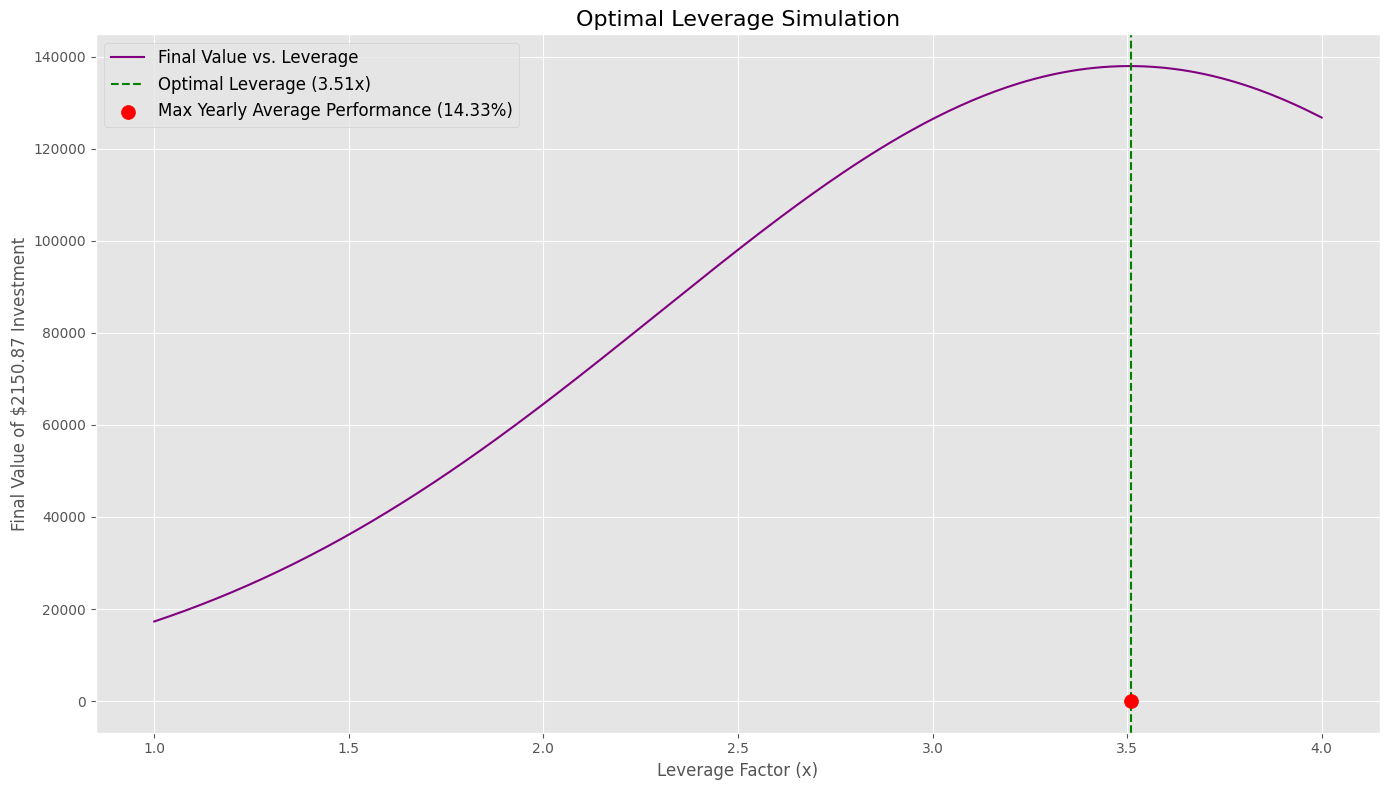


Optimal Leverage Found: 3.51x
Resulting Max Performance: $138,000.49
Resulting Max Performance: 64.16x


In [375]:
if not df.empty:
    # --- Batch Simulation to Find Optimal Leverage ---
    print("Running batch simulation... This may take a moment.")

    # 1. Define the range of leverages to test
    leverage_range = np.arange(1.0, 4.01, 0.01)

    # List to store the final results (leverage, final_performance)
    results = []

    # Store the initial price for calculating growth
    initial_price = df[price_col].iloc[0]

    # 2. Loop through each leverage factor
    for l_factor in leverage_range:

        # --- Recalculate all costs for the current leverage factor ---

        # Dynamic Expense Ratio
        current_er = ter_function(l_factor)

        # Recalculate all components that depend on leverage
        gross_return = l_factor * df['Index_Return']
        daily_financing_cost = (l_factor - 1) * (SOFR_RATE + SWAP_SPREAD) / 365
        daily_er_cost = (1 + current_er)**(1/365) - 1
        daily_trading_cost = df['Index_Return'].abs() * l_factor * TRADING_COST_FACTOR

        # Calculate the daily returns for this specific leverage
        letf_return_series = gross_return - daily_financing_cost - daily_er_cost - daily_trading_cost

        # Calculate the final cumulative performance for this run
        final_performance = initial_price * (1 + letf_return_series).cumprod().iloc[-1]

        # Store the result
        results.append((l_factor, final_performance))

    print("Batch simulation complete.")

    # 3. Convert results to a DataFrame for analysis and plotting
    results_df = pd.DataFrame(results, columns=['Leverage', 'Final_Performance'])

    # 4. Find the optimal leverage
    optimal_point = results_df.loc[results_df['Final_Performance'].idxmax()]
    optimal_leverage = optimal_point['Leverage']

    final_return = optimal_point['Final_Performance']
    final_multiplier = final_return / 100
    yearly_multiplier = final_multiplier**(1/54)

    max_performance = (yearly_multiplier - 1) * 100

    # 5. Plot the results
    plt.figure(figsize=(14, 8))
    plt.plot(results_df['Leverage'], results_df['Final_Performance'], label='Final Value vs. Leverage', color='purple')

    # Highlight the optimal point
    plt.axvline(x=optimal_leverage, color='green', linestyle='--', label=f'Optimal Leverage ({optimal_leverage:.2f}x)')
    plt.scatter(optimal_leverage, max_performance, color='red', s=100, zorder=5,
                label=f'Max Yearly Average Performance ({max_performance:,.2f}%)')

    # Formatting
    plt.title('Optimal Leverage Simulation', fontsize=16)
    plt.xlabel('Leverage Factor (x)', fontsize=12)
    plt.ylabel(f'Final Value of ${initial_price:.2f} Investment', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nOptimal Leverage Found: {optimal_leverage:.2f}x")
    print(f"Resulting Max Performance: ${final_return:,.2f}")
    print(f"Resulting Max Performance: {final_return / 2150.87:,.2f}x")
